In [43]:
import numpy as np
import torch
import gym
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
import torch.optim as optim
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
gym.__version__

'0.19.0'

In [22]:
env_id = 'BipedalWalker-v3'
env = gym.make(env_id)
env.seed(10)

[10]

In [23]:
# switch to GPU if available (Udacity env)
device = torch.device("cpu")

BUFFER_SIZE = 50_000 #max number of experiences in a buffer
MINI_BATCH = 100 #number of samples to collect from buffer

In [24]:
state_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

In [25]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, max_action, fc1=256, fc2=256):
        """
        Initializes actor object.
        @Param:
        1. state_size: env.observation_space.shape[0].
        2. action_size: env.action_space.shape[0].
        3. max_action: abs(env.action_space.low), sets boundary/clip for policy approximation.
        4. fc1: number of hidden units for the first fully connected layer, fc1. Default = 256.
        5. fc2: number of hidden units for the second fully connected layer, fc1. Default = 256.
        """
        super(Actor, self).__init__()

        #Layer 1
        self.fc1 = nn.Linear(state_size, fc1)
        #Layer 2
        self.fc2 = nn.Linear(fc1, fc2)
        #Layer 3
        self.mu = nn.Linear(fc2, action_size)

        #Define boundary for action space.
        self.max_action = max_action
    
    def forward(self, state):
        """Peforms forward pass to map state--> pi(s)"""
        #Layer 1
        x = self.fc1(state)
        x = F.relu(x)
        #Layer 2
        x = self.fc2(x)
        x = F.relu(x)
        #Output layer
        mu = torch.tanh(self.mu(x))#set action b/w -1 and +1
        return self.max_action * mu

In [26]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, fc1=256, fc2=256):
        """
        Initializes Critic object, Q1 and Q2.
        Architecture different from DDPG. See paper for full details.
        @Param:
        1. state_size: env.observation_space.shape[0].
        2. action_size: env.action_space.shape[0].
        3. fc1: number of hidden units for the first fully connected layer, fc1. Default = 256.
        4. fc2: number of hidden units for the second fully connected layer, fc1. Default = 256.
        """
        super(Critic, self).__init__()

        #---------Q1 architecture---------
        
        #Layer 1
        self.l1 = nn.Linear(state_size + action_size, fc1)
        #Layer 2
        self.l2 = nn.Linear(fc1, fc2)
        #Output layer
        self.l3 = nn.Linear(fc2, 1)#Q-value

        #---------Q2 architecture---------

        #Layer 1
        self.l4 = nn.Linear(state_size + action_size, fc1)
        #Layer 2
        self.l5 = nn.Linear(fc1, fc2)
        #Output layer
        self.l6 = nn.Linear(fc2, 1)#Q-value
    
    def forward(self, state, action):
        """Perform forward pass by mapping (state, action) --> Q-value"""
        x = torch.cat([state, action], dim=1) #concatenate state and action such that x.shape = state.shape + action.shape

        #---------Q1 critic forward pass---------
        #Layer 1
        q1 = F.relu(self.l1(x))
        #Layer 2
        q1 = F.relu(self.l2(q1))
        #value prediction for Q1
        q1 = self.l3(q1)

        #---------Q2 critic forward pass---------
        #Layer 1
        q2 = F.relu(self.l4(x))
        #Layer 2
        q2 = F.relu(self.l5(q2))
        #value prediction for Q2
        q2 = self.l6(q2)

        return q1, q2

In [27]:
class ReplayBuffer():
    """
    Implementation of a fixed size replay buffer as used in DQN algorithms.
    The goal of a replay buffer is to unserialize relationships between sequential experiences, gaining a better temporal understanding.
    """
    def __init__(self, buffer_size=BUFFER_SIZE, batch_size=MINI_BATCH):
        """
        Initializes the buffer.
        @Param:
        1. action_size: env.action_space.shape[0]
        2. buffer_size: Maximum length of the buffer for extrapolating all experiences into trajectories. default - 1e6 (Source: DeepMind)
        3. batch_size: size of mini-batch to train on. default = 64.
        """
        self.replay_memory = deque(maxlen=buffer_size) #Experience replay memory object
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"]) #standard S,A,R,S',done
        
    def add(self, state, action, reward, next_state, done):
        """Adds an experience to existing memory"""
        trajectory = self.experience(state, action, reward, next_state, done)
        self.replay_memory.append(trajectory)
    
    def sample(self):
        """Randomly picks minibatches within the replay_buffer of size mini_batch"""
        experiences = random.sample(self.replay_memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):#override default __len__ operator
        """Return the current size of internal memory."""
        return len(self.replay_memory)

In [28]:
BUFFER_SIZE = 50_000 #max number of experiences in a buffer
MINI_BATCH = 100 #number of samples to collect from buffer
exploration_noise = 0.1

In [34]:
class Agent():
    """Agent that plays and learn from experience. Hyper-paramters chosen from paper."""
    def __init__(
            self, 
            state_size, 
            action_size, 
            max_action, 
            discount=0.99,
            tau=0.005,
            policy_noise=0.2,
            noise_clip=0.5,
            policy_freq=2
        ):
        """
        Initializes the Agent.
        @Param:
        1. state_size: env.observation_space.shape[0]
        2. action_size: env.action_size.shape[0]
        3. max_action: list of max values that the agent can take, i.e. abs(env.action_space.high)
        4. discount: return rate
        5. tau: soft target update
        6. policy_noise: noise reset level, DDPG uses Ornstein-Uhlenbeck process
        7. noise_clip: sets boundary for noise calculation to prevent from overestimation of Q-values
        8. policy_freq: number of timesteps to update the policy (actor) after
        """
        super(Agent, self).__init__()

        #Actor Network initialization
        self.actor = Actor(state_size, action_size, max_action).to(device)
        self.actor.apply(self.init_weights)
        self.actor_target = copy.deepcopy(self.actor) #loads main model into target model
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=0.001)

        #Critic Network initialization
        self.critic = Critic(state_size, action_size).to(device)
        self.critic.apply(self.init_weights)
        self.critic_target = copy.deepcopy(self.critic) #loads main model into target model
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=0.001)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        self.total_it = 0

    def init_weights(self, layer):
        """Xaviar Initialization of weights"""
        if(type(layer) == nn.Linear):
          nn.init.xavier_normal_(layer.weight)
          layer.bias.data.fill_(0.01)

    def select_action(self, state):
        """Selects an automatic epsilon-greedy action based on the policy"""
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()
    
    def train(self, replay_buffer:ReplayBuffer):
        """Train the Agent"""

        self.total_it += 1

        # Sample replay buffer 
        state, action, reward, next_state, done = replay_buffer.sample()#sample 256 experiences

        with torch.no_grad():
            # Select action according to policy and add clipped noise
            noise = (
                torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)
            

            next_action = (
                self.actor_target(next_state) + noise #noise only set in training to prevent from overestimation
            ).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action) #Q1, Q2
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (1 - done) * self.discount * target_Q #TD-target

        # Get current Q estimates
        current_Q1, current_Q2 = self.critic(state, action) #Q1, Q2

        # Compute critic loss using MSE
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates (DDPG baseline = 1)
        if(self.total_it % self.policy_freq == 0):

            # Compute actor loss
            actor_loss = -self.critic(state, self.actor(state))[0].mean()
            
            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Soft update by updating the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


    def save(self, filename):
        """Saves the Actor Critic local and target models"""
        torch.save(self.critic.state_dict(), "TD3/models/checkpoint/"+ filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), "TD3/models/checkpoint/" + filename + "_critic_optimizer")

        torch.save(self.actor.state_dict(), "TD3/models/checkpoint/" + filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), "TD3/models/checkpoint/" + filename + "_actor_optimizer")


    def load(self, filename):
        """Loads the Actor Critic local and target models"""
        self.critic.load_state_dict(torch.load("TD3/models/checkpoint/" + filename + "_critic", map_location='cpu'))
        self.critic_optimizer.load_state_dict(torch.load("TD3/models/checkpoint/" + filename + "_critic_optimizer", map_location='cpu'))#optional
        self.critic_target = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load("TD3/models/checkpoint/" + filename + "_actor", map_location='cpu'))
        self.actor_optimizer.load_state_dict(torch.load("TD3/models/checkpoint/" + filename + "_actor_optimizer", map_location='cpu'))#optional
        self.actor_target = copy.deepcopy(self.actor)

In [36]:
#Set exploration noise for calculating action based on some noise factor
exploration_noise = 0.1

#Define observation and action space
state_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

#Create Agent
policy = Agent(state_space, action_space, max_action)

try:
    policy.load("final")
except:
    raise IOError("Couldn't load policy")

#Create Replay Buffer
replay_buffer = ReplayBuffer()


#Train the model
max_episodes = 500
max_timesteps = 2000

ep_reward = [] #get list of reward for range(max_episodes)

for episode in range(1, max_episodes+1):
    avg_reward = 0
    state = env.reset()
    for t in range(1, max_timesteps + 1):
        env.render()
        # select action and add exploration noise:
        action = policy.select_action(state) + np.random.normal(0, max_action * exploration_noise, size=action_space)
        action = action.clip(env.action_space.low, env.action_space.high)
            
        # take action in env:
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
            
        avg_reward += reward

        #Renders an episode
        # env.render()
        
        if(len(replay_buffer) > 100):#make sure sample is less than overall population
            policy.train(replay_buffer) #training mode

        # if episode is done then update policy:
        if(done or t >=max_timesteps):
            print(f"Episode {episode} reward: {avg_reward} | Rolling average: {np.mean(ep_reward)}")
            print(f"Current time step: {t}")
            
            ep_reward.append(avg_reward)
            break 
    
    if(np.mean(ep_reward[-10:]) >= 300):
        policy.save("final")
        break

    if(episode % 100 == 0 and episode > 0):
        #Save policy and optimizer every 100 episodes
        policy.save(str("%02d" % (episode//100)))
env.close()

Episode 1 reward: 81.96156351591387 | Rolling average: nan
Current time step: 1600
Episode 2 reward: 289.99563142760513 | Rolling average: 81.96156351591387
Current time step: 970
Episode 3 reward: 41.130888100581615 | Rolling average: 185.97859747175949
Current time step: 549
Episode 4 reward: 64.89517279715992 | Rolling average: 137.69602768136687
Current time step: 647
Episode 5 reward: 291.1728378025752 | Rolling average: 119.49581396031513
Current time step: 932
Episode 6 reward: 293.64777620053786 | Rolling average: 153.83121872876714
Current time step: 930
Episode 7 reward: -20.568913065047127 | Rolling average: 177.1339783073956
Current time step: 424
Episode 8 reward: 290.63151259495606 | Rolling average: 148.89070811133234
Current time step: 907
Episode 9 reward: -5.150197607100466 | Rolling average: 166.60830867178532
Current time step: 339
Episode 10 reward: 287.7897431869406 | Rolling average: 147.52403019635358
Current time step: 953
Episode 11 reward: -14.244912569119506

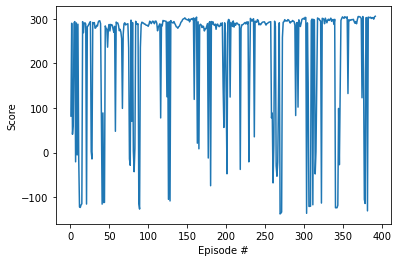

In [41]:
#Display Scores
fig = plt.figure()
plt.plot(np.arange(1, len(ep_reward) + 1), ep_reward)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

C:\Users\user\miniconda3\envs\ce802\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


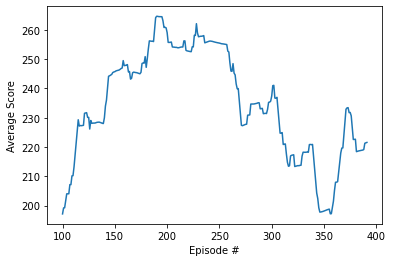

In [44]:
ay = fig.add_subplot(122)
plt.plot(np.arange(1, len(ep_reward)+1), pd.Series(ep_reward).rolling(100).mean())
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()